In [70]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import requests
import collections
import re
import json
import glob
import math
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist, pdist, squareform
import pandas.tseries.holiday as hol
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit

%matplotlib inline

In [2]:
trip_simp = pd.read_csv("../Data_processed/trip_simp.csv",parse_dates=["starttime", "stoptime"], index_col=0)
station_zip = pd.read_csv("../Data_processed/station_with_zipzone.csv", index_col=0)
tripmonth = pd.read_csv("../Data_processed/tripmonth.csv")
MBTA_subway = pd.read_csv("../Data_processed/MBTA_subway.csv", index_col=0)

/Users/kkim14/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
trip_simp.head(3)

,start_station_id,end_station_id,starttime,stoptime,tripduration,bikeid,counting
0,22,60,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,1
1,22,52,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,1
2,41,381,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,1


In [4]:
station_zip.head(3)

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes,Empty_Docks,Num_of_Docks,zip,zone
0,3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,11,0,11,2115,0
1,4,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,8,5,13,2116,0
2,5,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,4,5,9,2115,0


In [5]:
tripmonth.head(3)

,start_station_id,Jul17,Aug17,Sep17,Oct17,Nov17,Dec17,Jan18,Feb18,Mar18,...,Dec18,Jan19,Feb19,Mar19,Apr19,May19,Jun19,Jul19,Num_Op_Months,Ave_Trips_Per_Month
0,3,602.0,659.0,532.0,522.0,306.0,164.0,168.0,288.0,289.0,...,259.0,193.0,294.0,333.0,698.0,730.0,917.0,1090.0,25,523.48
1,4,1182.0,1299.0,1156.0,1056.0,722.0,473.0,311.0,400.0,434.0,...,441.0,369.0,375.0,454.0,861.0,1212.0,1513.0,1671.0,25,900.04
2,5,965.0,1053.0,953.0,929.0,587.0,127.0,NaN,NaN,NaN,...,412.0,190.0,NaN,NaN,593.0,1056.0,1249.0,1658.0,20,883.65


In [6]:
MBTA_subway.head(3)

,stop_name,stop_lat,stop_lon,red,orange,blue,greenE,greenD,greenC,greenB
0,Alewife,42.395428,-71.142483,True,False,False,False,False,False,False
1,Allston Street,42.348701,-71.137955,False,False,False,False,False,False,True
2,Andrew,42.330154,-71.057655,True,False,False,False,False,False,False


In [3]:
maindf=pd.merge(station_zip[["ID", "Latitude", "Longitude", "Num_of_Docks", "zip", "zone"]], tripmonth[["start_station_id", "Num_Op_Months", "Ave_Trips_Per_Month"]], 
                how="left", left_on="ID", right_on="start_station_id").drop("start_station_id", axis=1)


## Define variables
* nodes_bikes
* nodes_subway
* bikecenter
* dist_from_bikes_to_bikes
* mindist_from_bikes_to_subway
* dist_bikecenter
* dist_bikemit
* num_bikenodes_in_01
* biketripcount_in_01
* biketripcount_in_005
* mindist_to_pop



In [4]:
nodes_bikes=np.array(list(zip(maindf.Longitude, maindf.Latitude)))
nodes_subway=np.array(list(zip(MBTA_subway.stop_lon, MBTA_subway.stop_lat)))

In [5]:
# The most center point : the average distance to all other nodes is the smallest
avg_dists_nodes = squareform(pdist(nodes_bikes)).mean(axis=1)

bikecenter= nodes_bikes[avg_dists_nodes.argmin()]
maindf.iloc[[nodes_bikes.tolist().index([bikecenter[0], bikecenter[1]])]]

,ID,Latitude,Longitude,Num_of_Docks,zip,zone,Num_Op_Months,Ave_Trips_Per_Month
42,52,42.348717,-71.085954,20,2115,0,17.0,1895.058824


In [10]:
station_zip[station_zip.ID==52]

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes,Empty_Docks,Num_of_Docks,zip,zone
42,52,Newbury St at Hereford St,42.348717,-71.085954,Boston,14,6,20,2115,0


In [6]:
# distance from each bike station to bikecenter
dist_bikecenter= cdist(nodes_bikes, [nodes_bikes[52]])
maindf["dist_bikecenter"] = dist_bikecenter

In [7]:
# Shortest distance from each bike station to its nearest subwasy station
mindist_from_bikes_to_subway=np.min(cdist(nodes_bikes, nodes_subway)*1000, axis=1)
maindf["mindist_bikes_sub"]=mindist_from_bikes_to_subway

In [8]:
# Matrix which contains the pairwise distance between bike stations
dist_from_bikes_to_bikes=cdist(nodes_bikes, nodes_bikes)
num_bikenodes_in_01=[]
for i in range(len(nodes_bikes)):
    num_bikenodes_in_01.append(len(dist_from_bikes_to_bikes[i][dist_from_bikes_to_bikes[i]< 0.01]))
maindf["num_bikenodes_in_01"]=num_bikenodes_in_01

In [9]:
# Number of bike stations within radius 0.01 
biketripcount_in_01=[]
for i in range(len(nodes_bikes)):
    biketripcount_in_01.append(maindf.Ave_Trips_Per_Month[dist_from_bikes_to_bikes[i]<0.01].sum())
                               #+station_df.total_trip_count_y[stationdistance[i]<0.01].sum())
maindf["biketripcount_in_01"]=biketripcount_in_01

In [10]:
# Number of bike stations within radius 0.005
biketripcount_in_005=[]
for i in range(len(nodes_bikes)):
    biketripcount_in_005.append(maindf.Ave_Trips_Per_Month[dist_from_bikes_to_bikes[i]<0.005].sum())
                               #+station_df.total_trip_count_y[stationdistance[i]<0.005].sum())
maindf["biketripcount_in_005"]=biketripcount_in_005

In [11]:
maindf.head()

,ID,Latitude,Longitude,Num_of_Docks,zip,zone,Num_Op_Months,Ave_Trips_Per_Month,dist_bikecenter,mindist_bikes_sub,num_bikenodes_in_01,biketripcount_in_01,biketripcount_in_005
0,3,42.340115,-71.100619,11,2115,0,25.0,523.48,0.043420,4.193608,15,11600.669483,1692.414545
1,4,42.345392,-71.069616,13,2116,0,25.0,900.04,0.012314,6.417015,25,18642.517307,1797.520000
2,5,42.341814,-71.090179,9,2115,0,20.0,883.65,0.032878,1.970203,12,14828.281016,2454.730000
3,6,42.361212,-71.065306,12,2114,0,25.0,1439.48,0.018914,3.272792,18,20539.745810,4320.309091
4,7,42.353391,-71.044571,15,2210,0,25.0,407.96,0.015855,9.540003,13,9957.456910,3067.345455


In [12]:
# The line name of nearest subway station
nearest_subwayline=MBTA_subway.iloc[np.argmin(cdist(nodes_bikes, nodes_subway)*1000, axis=1)][["red", "orange", "blue", "greenE", "greenD", "greenC", "greenB" ]]
nearest_subwayline =nearest_subwayline.reset_index().drop("index", axis=1)

In [13]:
maindf=pd.concat([maindf, nearest_subwayline.astype(int)], axis=1)
maindf= maindf.dropna()

In [18]:
maindf.head()

,ID,Latitude,Longitude,Num_of_Docks,zip,zone,Num_Op_Months,Ave_Trips_Per_Month,dist_bikecenter,mindist_bikes_sub,num_bikenodes_in_01,biketripcount_in_01,biketripcount_in_005,red,orange,blue,greenE,greenD,greenC,greenB
0,3,42.340115,-71.100619,11,2115,0,25.0,523.48,0.043420,4.193608,15,11600.669483,1692.414545,0,0,0,1,0,0,0
1,4,42.345392,-71.069616,13,2116,0,25.0,900.04,0.012314,6.417015,25,18642.517307,1797.520000,0,1,0,0,0,0,0
2,5,42.341814,-71.090179,9,2115,0,20.0,883.65,0.032878,1.970203,12,14828.281016,2454.730000,0,0,0,1,0,0,0
3,6,42.361212,-71.065306,12,2114,0,25.0,1439.48,0.018914,3.272792,18,20539.745810,4320.309091,0,0,1,0,0,0,0
4,7,42.353391,-71.044571,15,2210,0,25.0,407.96,0.015855,9.540003,13,9957.456910,3067.345455,0,0,1,0,0,0,0


In [191]:
X=maindf.drop(["ID","Num_of_Docks","Num_Op_Months","zip","Ave_Trips_Per_Month"], axis=1)
y=maindf.Ave_Trips_Per_Month

In [196]:
X.head(3)

,Latitude,Longitude,zone,dist_bikecenter,mindist_bikes_sub,num_bikenodes_in_01,biketripcount_in_01,biketripcount_in_005,red,orange,blue,greenE,greenD,greenC,greenB
0,42.340115,-71.100619,0,0.043420,4.193608,15,11600.669483,1692.414545,0,0,0,1,0,0,0
1,42.345392,-71.069616,0,0.012314,6.417015,25,18642.517307,1797.520000,0,1,0,0,0,0,0
2,42.341814,-71.090179,0,0.032878,1.970203,12,14828.281016,2454.730000,0,0,0,1,0,0,0


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [193]:
GBregr = GradientBoostingRegressor(n_estimators=200, max_depth=7)
GBregr.fit(X_train, np.log(y_train))
print(GBregr.score(X_train, np.log(y_train)))
print(GBregr.score(X_test, np.log(y_test)))


print(cross_validate(GBregr, X_train, np.log(y_train), cv=5)["test_score"])

0.9999998442315837
0.7862519209328598
[0.78881722 0.85997173 0.67392842 0.86662225 0.47003106]


In [194]:
ypredict=GBregr.predict(X_test)

(0, 9)

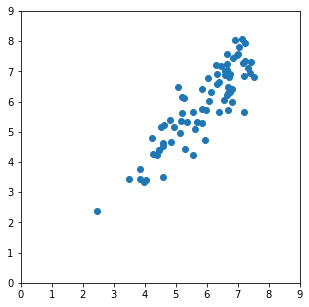

In [186]:
plt.subplots(figsize=(5,5))
plt.scatter(ypredict, np.log(y_test))
plt.xlim(0, 9)
plt.ylim(0, 9)

In [24]:
from keras.models import Model
from keras.layers import Dense
from keras.models import Sequential

In [119]:
n_cols = len(X.columns)

# Set up the model: model
model = Sequential()

# Add the first layer
model.add(Dense(100, activation='relu', input_shape=(n_cols, )))

# Add the second layer
model.add(Dense(100, activation='relu'))

# Add the output layer
model.add(Dense(1))

In [120]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, np.log(y_train))

Epoch 1/1
224/224 [==============================] - 1s 3ms/step - loss: 2337687.2168


In [121]:
predict=model.predict(X_test)

In [162]:
predict[:,0][-7]

-0.15320452

(0, 3500)

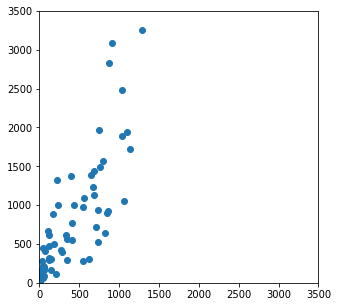

In [123]:
plt.subplots(figsize=(5,5))
plt.scatter(predict[:,0], np.log(y_test))
#plt.scatter(np.log(ypredict), np.log(y_test))
#plt.xlim(0, 3500)
#plt.ylim(0, 3500)